# **Import Library**


---



In [220]:
import re
from collections import Counter
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from wordcloud import WordCloud

# PyVi
from pyvi import ViTokenizer
from pyvi import ViPosTagger

# NLTK
import nltk
from nltk.tokenize import word_tokenize

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# **Dataset**


---



In [221]:
data = pd.read_csv('Reviews.csv', header = 0, index_col = 0)

# **1. EDA - Exploratory Data Analysis**


---



## **Data Infomation**
---

In [222]:
data.head()

,language,rating,additionalRatings,createdDate,helpfulVotes,username,userId,title,text,locationId,parentGeoId,hotelName,stayDate,tripType
id,,,,,,,,,,,,,,
654797953,vi,4,[],2019-02-25,1,Lephuchau,F31010A9913D4D5EF71C19943112119E,Một đêm khó ngủ,- Nằm ở số 4 Tôn Đức Thắng (trong khu villa ca...,14775963,651661,Hana Riverside Villa,2019-02-28,COUPLES
759960236,en,4,"[{'rating': 5, 'ratingLabel': 'Sự sạch sẽ'}, {...",2020-07-14,0,Lê T,5EEE52E4A46EB17EDB101F2687176104,Nice choice for short stay (hope the contructi...,"Hana Riverside Quang Ngai hotel, - Located in ...",14775963,651661,Hana Riverside Villa,2020-02-29,NONE
746020346,en,5,[],2020-02-18,0,Pipes79,9266F1E4EB6B7888598CAFA3CA535D94,Lovely stay,Dropped in here for 1 night on my way north. F...,14775963,651661,Hana Riverside Villa,2020-02-29,SOLO
710719324,en,4,[],2019-09-17,0,Chels2210,2930D0F21694986E614640B46EAC7FF6,Good room,Stayed here for one night while passing throug...,14775963,651661,Hana Riverside Villa,2019-09-30,COUPLES
658526310,vi,4,[],2019-03-14,0,Andy M,A1C68DD5908359E499974361DADF0117,Một công việc đang tiến triển - theo nghĩa đen.,"Khách sạn đẹp, nhân viên và các cơ sở nhưng cô...",14775963,651661,Hana Riverside Villa,2019-03-31,SOLO


In [223]:
# Metadata
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62887 entries, 654797953 to 788466559
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   language           62887 non-null  object
 1   rating             62887 non-null  int64 
 2   additionalRatings  62887 non-null  object
 3   createdDate        62887 non-null  object
 4   helpfulVotes       62887 non-null  int64 
 5   username           62424 non-null  object
 6   userId             62432 non-null  object
 7   title              62885 non-null  object
 8   text               62887 non-null  object
 9   locationId         62887 non-null  int64 
 10  parentGeoId        62887 non-null  int64 
 11  hotelName          62887 non-null  object
 12  stayDate           62887 non-null  object
 13  tripType           62887 non-null  object
dtypes: int64(4), object(10)
memory usage: 7.2+ MB


Number of Rows, Columns

In [224]:
# Kiểm tra tên, số giá trị unique, null và kiểu dữ liệu của cột
properties_check = pd.DataFrame({
        'Số quan sát': data.count(),
        'Số giá trị unique': data.nunique(),
        'Kiểu dữ liệu': data.dtypes.values
    })

print(properties_check)

                   Số quan sát  Số giá trị unique Kiểu dữ liệu
language                 62887                 14       object
rating                   62887                  5        int64
additionalRatings        62887               2546       object
createdDate              62887               4659       object
helpfulVotes             62887                 52        int64
username                 62424              54130       object
userId                   62432              56836       object
title                    62885              51910       object
text                     62887              62863       object
locationId               62887               1497        int64
parentGeoId              62887                185        int64
hotelName                62887               1470       object
stayDate                 62887                202       object
tripType                 62887                  6       object


---
## **Lọc các reviews tiếng Việt**
---

In [225]:
data = data[data['language']=='vi']

---
# **2. Pre-Processing**


---
## **Tạo dataframe *'data_sentiment'* để Sentiment Analysis**
---

### *Loại bỏ các biến không sử dụng*

In [226]:
data_sentiment = data[['rating', 'title', 'text']]
data_sentiment.head()

,rating,title,text
id,,,
654797953,4,Một đêm khó ngủ,- Nằm ở số 4 Tôn Đức Thắng (trong khu villa ca...
658526310,4,Một công việc đang tiến triển - theo nghĩa đen.,"Khách sạn đẹp, nhân viên và các cơ sở nhưng cô..."
750938266,1,không có một chút nào là thoải mái,tham quan để giới thiệu cho khu này thì bắt bu...
732133832,5,Tuyệt vời và Nghỉ dưỡng số 1 Quảng Ngãi,Tôi có dịp công tác tại Quảng Ngãi và được giớ...
704760303,5,Một nơi nghỉ dưỡng tuyệt vời.,"Resort mới khai trương nên còn vắng vẻ, yên tĩ..."


In [227]:
data_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15364 entries, 654797953 to 788466559
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  15364 non-null  int64 
 1   title   15364 non-null  object
 2   text    15364 non-null  object
dtypes: int64(1), object(2)
memory usage: 480.1+ KB


### *Xử lý Missing Values & Duplicate Values*

In [228]:
# Kiểm tra Missing Values
missing_values = data_sentiment.isnull().sum()

# Kiểm tra giá trị trùng lặp
duplicate_values = data_sentiment.duplicated().sum()
pd.DataFrame({'Missing Values': missing_values, 'Duplicate Values': duplicate_values})

,Missing Values,Duplicate Values
rating,0,2
title,0,2
text,0,2


In [229]:
# Xử lý Duplicate Values
data_sentiment[data_sentiment.duplicated()]

,rating,title,text
id,,,
681613303,5,Hoàn hảo!,Tôi và gia đình vừa có một kỳ nghỉ rất tuyệt v...
604482723,3,Dịch vụ tốt,Nhà trọ rất sạch sẽ. Các nhân viên rất thân th...


In [230]:
# Loại bỏ Duplicate Values
data_sentiment = data_sentiment.drop_duplicates(keep = 'first')
data_sentiment.shape

(15362, 3)

### *Gộp cột 'title' và 'text' thành 'review'*

In [231]:
data_sentiment['review'] = data_sentiment['title'] + ' ' + data_sentiment['text']

# Drop 2 biến title và text cũ
data_sentiment = data_sentiment.drop(labels=['title','text'] , axis=1)
data_sentiment.head()

,rating,review
id,,
654797953,4,Một đêm khó ngủ - Nằm ở số 4 Tôn Đức Thắng (tr...
658526310,4,Một công việc đang tiến triển - theo nghĩa đen...
750938266,1,không có một chút nào là thoải mái tham quan đ...
732133832,5,Tuyệt vời và Nghỉ dưỡng số 1 Quảng Ngãi Tôi có...
704760303,5,Một nơi nghỉ dưỡng tuyệt vời. Resort mới khai ...


---
## **Tạo cột 'sentiment'**
---

In [232]:
# Thêm cột sentiment dựa trên giá trị rating
def rating_sentiment(rating):
    if rating < 3:
        return 'negative'
    elif rating > 3:
        return 'positive'
    else:
        return 'neutral'

data_sentiment['sentiment'] = data_sentiment['rating'].apply(rating_sentiment)

data_sentiment.head()

,rating,review,sentiment
id,,,
654797953,4,Một đêm khó ngủ - Nằm ở số 4 Tôn Đức Thắng (tr...,positive
658526310,4,Một công việc đang tiến triển - theo nghĩa đen...,positive
750938266,1,không có một chút nào là thoải mái tham quan đ...,negative
732133832,5,Tuyệt vời và Nghỉ dưỡng số 1 Quảng Ngãi Tôi có...,positive
704760303,5,Một nơi nghỉ dưỡng tuyệt vời. Resort mới khai ...,positive


---
## **Xử lý biến 'review'**
---

In [233]:
def remove_pattern(text):
    # Xóa dấu câu và ký tự đặc biệt
    text = re.sub(r'[^\w\s]', '', text)
    # Xóa khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    # Chuyển văn bản thành chữ thường
    text = text.lower()
    return text

data_sentiment['cleaned review'] = data_sentiment['review'].apply(remove_pattern)
data_sentiment.head()

,rating,review,sentiment,cleaned review
id,,,,
654797953,4,Một đêm khó ngủ - Nằm ở số 4 Tôn Đức Thắng (tr...,positive,một đêm khó ngủ nằm ở số 4 tôn đức thắng trong...
658526310,4,Một công việc đang tiến triển - theo nghĩa đen...,positive,một công việc đang tiến triển theo nghĩa đen k...
750938266,1,không có một chút nào là thoải mái tham quan đ...,negative,không có một chút nào là thoải mái tham quan đ...
732133832,5,Tuyệt vời và Nghỉ dưỡng số 1 Quảng Ngãi Tôi có...,positive,tuyệt vời và nghỉ dưỡng số 1 quảng ngãi tôi có...
704760303,5,Một nơi nghỉ dưỡng tuyệt vời. Resort mới khai ...,positive,một nơi nghỉ dưỡng tuyệt vời resort mới khai t...


---
## **Kiểm tra dữ liệu sau khi clean**
---

In [234]:
# Hàm kiểm tra ký tự bất thường
def check_abnormal_characters(text):
    # Kiểm tra xem có ký tự khác thường nào ngoài 'chữ', 'số', 'khoảng trắng'
    abnormal_chars = re.findall(r'[^\w\s]', text)
    return abnormal_chars

# Biến đếm
count_with_abnormal = 0
count_without_abnormal = 0

# Lặp qua từng dòng trong cột 'cleaned review' và kiểm tra
for index, row in data_sentiment.iterrows():
    cleaned_review = row['cleaned review']
    abnormal_chars = check_abnormal_characters(cleaned_review)
    if abnormal_chars:
        count_with_abnormal += 1
    else:
        count_without_abnormal += 1

print(f"Số dòng có ký tự bất thường: {count_with_abnormal}")
print(f"Số dòng không có ký tự bất thường: {count_without_abnormal}")


Số dòng có ký tự bất thường: 0
Số dòng không có ký tự bất thường: 15362


---
## **XỬ LÝ CÁC TỪ KHÔNG CÓ TRONG TIẾNG VIỆT**
---

In [235]:
#Lấy các giá trị review
reviews = data_sentiment['cleaned review']
reviews

id
654797953    một đêm khó ngủ nằm ở số 4 tôn đức thắng trong...
658526310    một công việc đang tiến triển theo nghĩa đen k...
750938266    không có một chút nào là thoải mái tham quan đ...
732133832    tuyệt vời và nghỉ dưỡng số 1 quảng ngãi tôi có...
704760303    một nơi nghỉ dưỡng tuyệt vời resort mới khai t...
                                   ...                        
853818514    khách sạn mới chuẩn 5 sao gần biển view đep đi...
533757203    khách sạn tốt duy nhất ở tam dương các khách s...
529028174    khách sạn tốt sau chuyến đi sapa chúng tôi đã ...
788473940    rất tuyệt vời cho chuyến công tác tại đức hòa ...
788466559    khách sạn đẹp nhất tiện nghi sang trọng nhất h...
Name: cleaned review, Length: 15362, dtype: object

In [ ]:
nltk.download('punkt_tab')

In [236]:
# Function to remove words that are not in the word list
def remove_words_not_in_list(text):
    # Read the word list from "TuDon.txt"
    with open('TuDon.txt', 'r', encoding='utf-8') as file:
      word_list = file.read().splitlines()
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word in word_list]
    return ' '.join(filtered_tokens)

reviews = reviews.apply(remove_words_not_in_list)
reviews

id
654797953    một đêm khó ngủ nằm ở số tôn đức thắng trong k...
658526310    một công việc đang tiến triển theo nghĩa đen k...
750938266    không có một chút nào là thoải mái tham quan đ...
732133832    tuyệt vời và nghỉ dưỡng số quảng ngãi tôi có d...
704760303    một nơi nghỉ dưỡng tuyệt vời mới khai trương n...
                                   ...                        
853818514    khách sạn mới chuẩn sao gần biển điều ấn tượng...
533757203    khách sạn tốt duy nhất ở tam dương các khách s...
529028174    khách sạn tốt sau chuyến đi chúng tôi đã đi đế...
788473940    rất tuyệt vời cho chuyến công tác tại đức hòa ...
788466559    khách sạn đẹp nhất tiện nghi sang trọng nhất h...
Name: cleaned review, Length: 15362, dtype: object

---
## **Correcting Spelling, Tokenizing Text, Removing Stop Words**
---

In [237]:
def process_text(text, stop_words_path):
    # Load file vietnamese-stopwords
    with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
        stop_words = [word.strip() for word in file.readlines()]

    # Sửa lỗi chính tả và tokenize
    words = ViTokenizer.tokenize(text)
    corrected_words = ViPosTagger.postagging(words)
    corrected_text = ' '.join(corrected_words[0])

    # Loại bỏ stopword
    if isinstance(corrected_text, str):
        filtered_words = [word for word in corrected_text.split() if word.lower() not in stop_words]
        return ' '.join(filtered_words)
    else:
        return ''

reviews = reviews.apply(lambda x: process_text(x, 'vietnamese.txt'))

In [238]:
reviews

id
654797953    đêm ngủ nằm tôn đức thắng khu cao_cấp đối_diện...
658526310    công_việc tiến_triển nghĩa_đen khách_sạn đẹp n...
750938266    một_chút nào_là thoải_mái tham_quan giới_thiệu...
732133832    tuyệt_vời nghỉ_dưỡng quảng_ngãi dịp công_tác q...
704760303    nghỉ_dưỡng tuyệt_vời khai_trương vắng_vẻ yên_t...
                                   ...                        
853818514    khách_sạn chuẩn biển ấn_tượng đầu_tiên khách_s...
533757203    khách_sạn duy_nhất tam_dương khách_sạn thương_...
529028174    khách_sạn chuyến đi chúng_tôi đi bình_minh huy...
788473940    tuyệt_vời chuyến công_tác đức hòa long an chuy...
788466559    khách_sạn đẹp tiện_nghi sang_trọng huyện đức h...
Name: cleaned review, Length: 15362, dtype: object

---
## **Gộp vào lại dataframe**
---

In [239]:
merged_data = pd.concat([data_sentiment['sentiment'], reviews], axis=1)
merged_data.head()

,sentiment,cleaned review
id,,
654797953,positive,đêm ngủ nằm tôn đức thắng khu cao_cấp đối_diện...
658526310,positive,công_việc tiến_triển nghĩa_đen khách_sạn đẹp n...
750938266,negative,một_chút nào_là thoải_mái tham_quan giới_thiệu...
732133832,positive,tuyệt_vời nghỉ_dưỡng quảng_ngãi dịp công_tác q...
704760303,positive,nghỉ_dưỡng tuyệt_vời khai_trương vắng_vẻ yên_t...


---
## **Tạo 'model_data' dùng để train model**
---

In [240]:
# Lọc dữ liệu có nhãn 'positive' (lấy 1500 dòng)
positive_data = merged_data[merged_data['sentiment'] == 'positive'].head(1500)

# Lọc dữ liệu có nhãn 'negative' và 'neutral' (lấy tất cả)
negative_neutral_data = merged_data[merged_data['sentiment'].isin(['negative', 'neutral'])]

# Kết hợp dữ liệu lại (1500 dòng positive và tất cả dòng negative/neutral)
model_data = pd.concat([positive_data, negative_neutral_data])

In [241]:
model_data

,sentiment,cleaned review
id,,
654797953,positive,đêm ngủ nằm tôn đức thắng khu cao_cấp đối_diện...
658526310,positive,công_việc tiến_triển nghĩa_đen khách_sạn đẹp n...
732133832,positive,tuyệt_vời nghỉ_dưỡng quảng_ngãi dịp công_tác q...
704760303,positive,nghỉ_dưỡng tuyệt_vời khai_trương vắng_vẻ yên_t...
701494562,positive,địa_điểm lý_tưởng quảng_ngãi vô_tình ghé khách...
...,...,...
603545186,neutral,ồn_ào gia_đình phòng thời_gian chúng_tôi tổ_ch...
580033066,neutral,chỗ ok chỗ sạch_sẽ hòa không_khí tuy_nhiên chỗ...
481491640,negative,kiểm_tra đi chúng_tôi du_lịch đồng_bằng sông c...


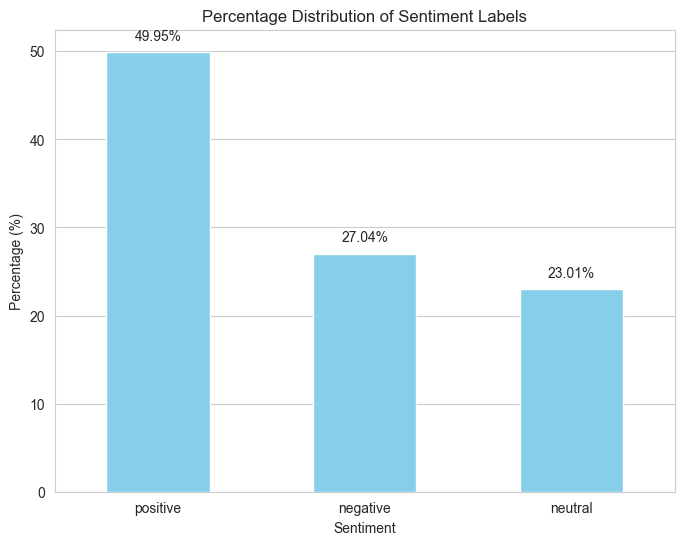

In [242]:
# Tính tỷ lệ phần trăm của các nhãn trong cột 'sentiment'
label_percentage = model_data['sentiment'].value_counts(normalize=True) * 100

# Vẽ biểu đồ cột tỷ lệ phần trăm
plt.figure(figsize=(8, 6))
label_percentage.plot(kind='bar', color='skyblue')

# Thêm tiêu đề và nhãn
plt.title('Percentage Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.grid(axis='x')
plt.xticks(rotation=0)

# Hiển thị tỷ lệ phần trăm trên từng cột
for i, v in enumerate(label_percentage):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom')

# Hiển thị biểu đồ
plt.show()

---
# **3. Data Visualization**
---

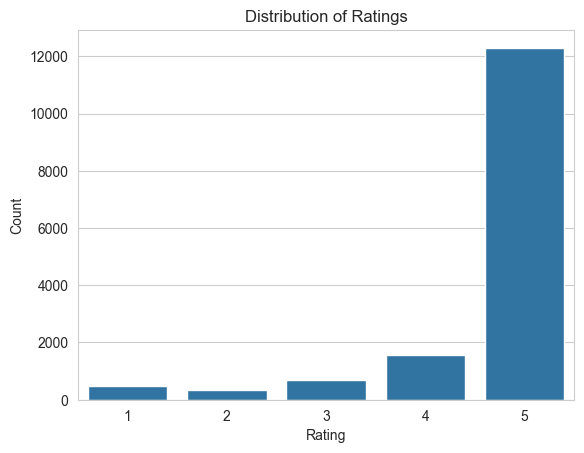

In [243]:
#Số lượng các đánh giá
sns.countplot(x='rating', data=data)

# Đặt tên cho các trục và tiêu đề cho biểu đồ
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

# Hiển thị biểu đồ
plt.show()

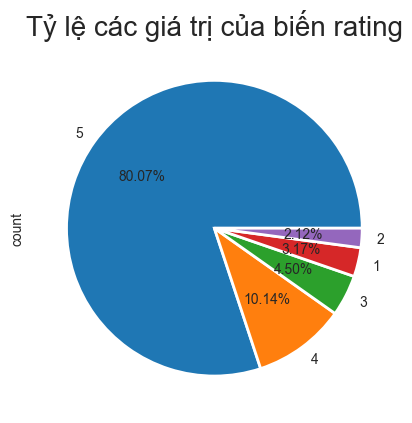

In [244]:
#Tỉ lệ các đánh giá
plt.title('Tỷ lệ các giá trị của biến rating', size = 20)
data['rating'].value_counts().plot.pie(autopct='%1.2f%%', wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' } )
plt.show()

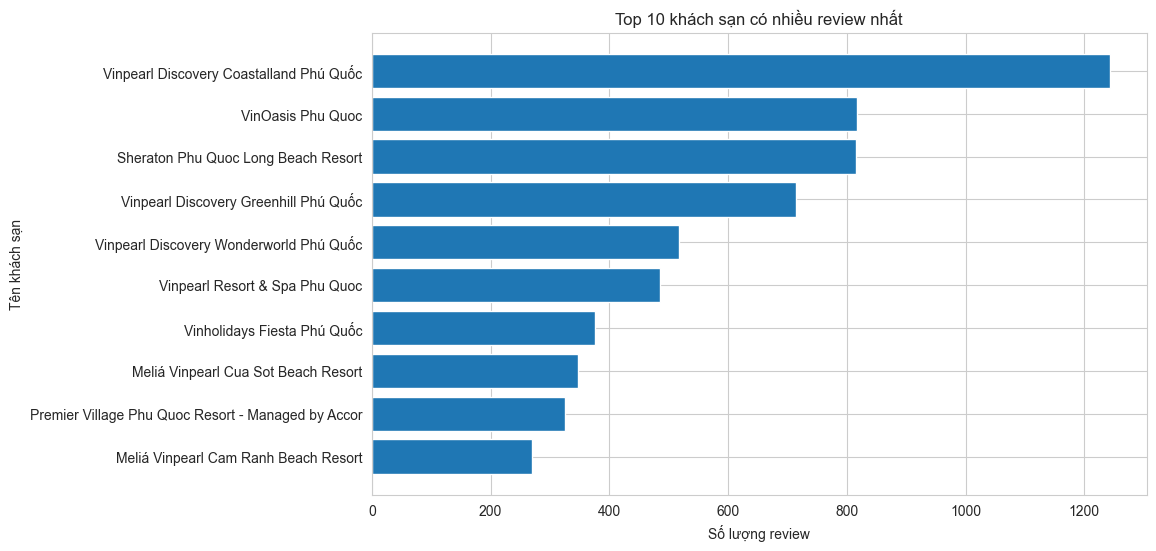

In [245]:
#Top 10 khách sạn có nhiều review nhất

# Tính số lượng review cho mỗi khách sạn
hotel_reviews = data['hotelName'].value_counts()

# Lấy top 10 khách sạn có nhiều review nhất
top_10_hotels = hotel_reviews.head(10)

# Vẽ biểu đồ cột nằm ngang
plt.figure(figsize=(10, 6))
plt.barh(top_10_hotels.index, top_10_hotels.values)
plt.xlabel('Số lượng review')
plt.ylabel('Tên khách sạn')
plt.title('Top 10 khách sạn có nhiều review nhất')
plt.gca().invert_yaxis()
plt.show()

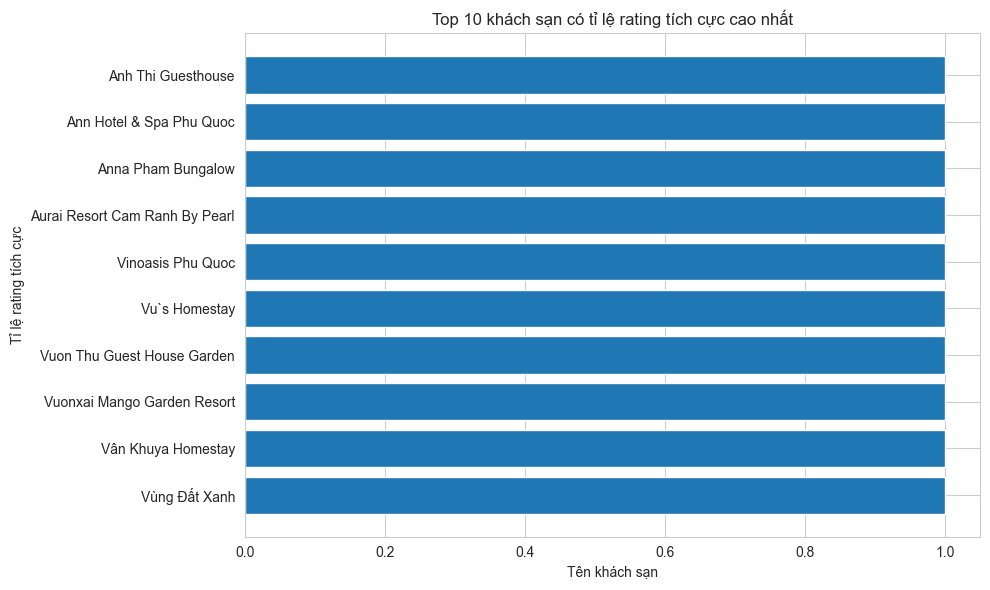

In [246]:
# Top 10 khách sạn có tỉ lệ rating "positive" (4 hoặc 5) cao nhất trên tổng số rating của khách sạn đó

# Tính tỉ lệ rating tích cực (4 hoặc 5) cho mỗi khách sạn
positive_ratings = data[data['rating'] >= 4].groupby('hotelName')['rating'].count()
total_ratings = data.groupby('hotelName')['rating'].count()
positive_ratio = positive_ratings / total_ratings

# Sắp xếp theo tỉ lệ rating tích cực giảm dần và lấy top 10
top_10_positive_hotels = positive_ratio.sort_values(ascending=False).head(10)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.barh(top_10_positive_hotels.index, top_10_positive_hotels.values)
plt.xlabel('Tên khách sạn')
plt.ylabel('Tỉ lệ rating tích cực')
plt.title('Top 10 khách sạn có tỉ lệ rating tích cực cao nhất')
plt.tight_layout() # Điều chỉnh bố cục để tránh nhãn bị cắt
plt.show()

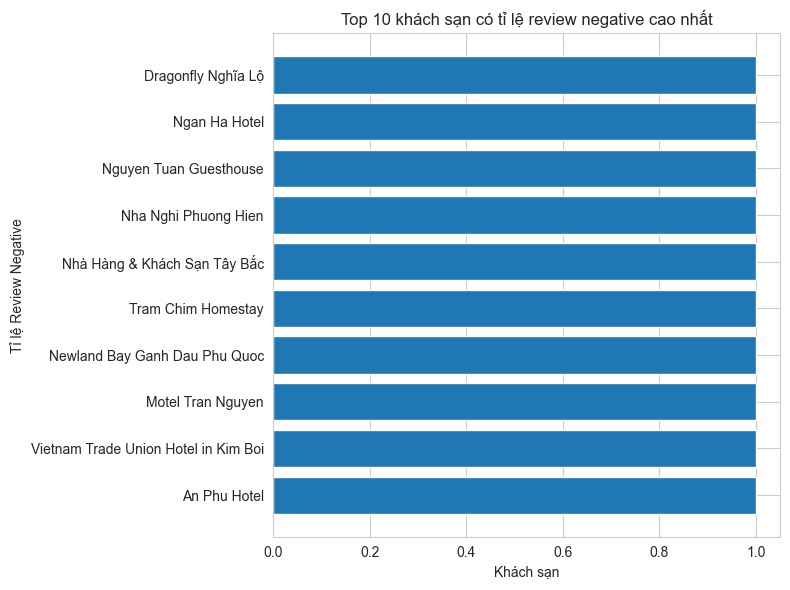

In [247]:
# Top10 khách sạn có tỉ lệ review negative cao nhất
# Tính tỉ lệ rating tích cực (1 hoặc 2) cho mỗi khách sạn
negative_ratings = data[data['rating'] <= 2].groupby('hotelName')['rating'].count()
total_ratings = data.groupby('hotelName')['rating'].count()
negative_ratio = negative_ratings / total_ratings
positive_ratio = 1 - negative_ratio

# Sắp xếp theo tỉ lệ rating tích cực giảm dần và lấy top 10
top_10_negative_hotels = negative_ratio.sort_values(ascending=False).head(10)

# Vẽ biểu đồ cột chồng
plt.figure(figsize=(8, 6))
plt.barh(top_10_negative_hotels.index, top_10_negative_hotels.values, label='Negative Reviews')
plt.xlabel('Khách sạn')
plt.ylabel('Tỉ lệ Review Negative')
plt.title('Top 10 khách sạn có tỉ lệ review negative cao nhất')
plt.tight_layout()
plt.show()

---
## **WORDCLOUD**
---

In [248]:
# Hàm tính tần suất từ
def calculate_frequent_words(reviews, top_n=10):
    all_reviews = ' '.join(reviews)
    words = all_reviews.split()
    word_counts = Counter(words)
    top_words = word_counts.most_common(top_n)
    return word_counts, top_words

word_counts, top_10_words = calculate_frequent_words(reviews, top_n=10)

# In ra kết quả
print('Top 10 từ được xuất hiện nhiều nhất:')
for word, count in top_10_words:
    print(f"{word}: {count}")

Top 10 từ được xuất hiện nhiều nhất:
chúng_tôi: 16254
phòng: 12428
nhân_viên: 11963
tuyệt_vời: 10737
đẹp: 8914
khách_sạn: 8536
đi: 8113
gia_đình: 7096
nhiệt_tình: 5682
dịch_vụ: 5547


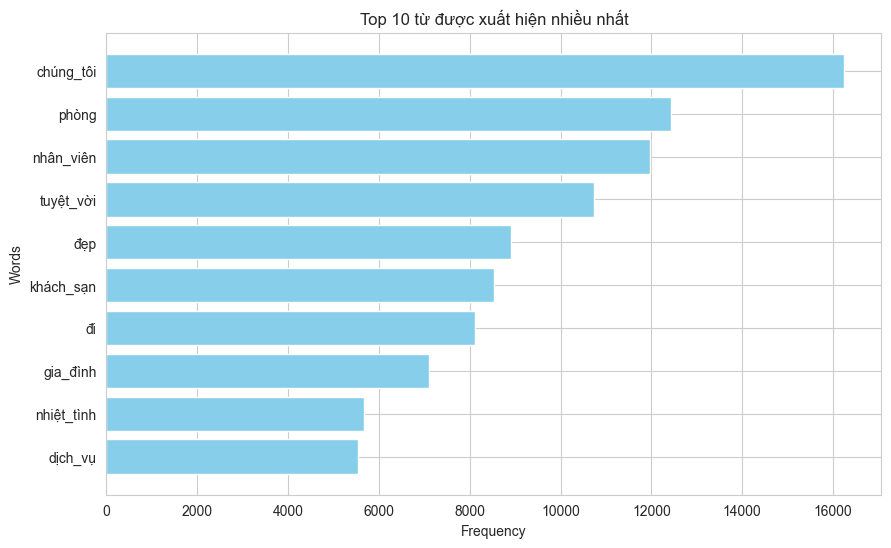

In [249]:
# Biểu diễn bằng biểu đồ
def plot_horizontal_bar(top_words):
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title('Top 10 từ được xuất hiện nhiều nhất')
    plt.gca().invert_yaxis()
    plt.show()


plot_horizontal_bar(top_10_words)


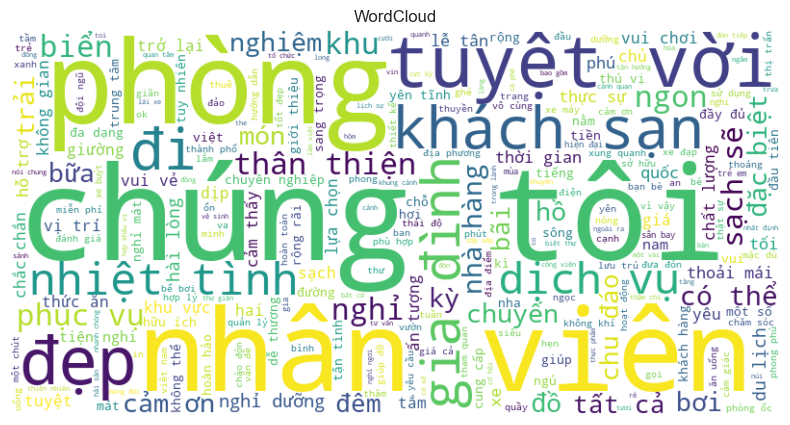

In [250]:
#WordCloud
def plot_wordcloud(word_counts):
    wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=250,
    collocations=False
).generate_from_frequencies(word_counts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("WordCloud")
    plt.show()

# Thay thế dấu '_' bằng khoảng trắng
word_counts_cleaned = {key.replace('_', ' '): value for key, value in word_counts.items()}
plot_wordcloud(word_counts_cleaned)

---
# **4. Machine Learning Model**


In [251]:
# Hàm vẽ ma trận nhầm lẫn
def plot_confusion_matrix(y_true, y_pred, model_classes, title='Confusion Matrix (%)'):
    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)

    # Tính tỷ lệ phần trăm
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Vẽ ma trận nhầm lẫn dưới dạng heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=model_classes, yticklabels=model_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

---
## **TF-IDF Vectorizer**
---

In [252]:
X = model_data['cleaned review']
y = model_data['sentiment']

In [253]:
# Split dataset: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [254]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

---
## **Multinominal Logistic Regression**
---

In [255]:
# Định nghĩa param_grid
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'max_iter': [100, 200, 500]
}

# Khởi tạo mô hình và GridSearchCV
logistic_model = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Huấn luyện mô hình
logistic_model.fit(X_train_tfidf, y_train)

# In kết quả
print("Best Parameters:", logistic_model.best_params_)
print("Best Cross-Validation Accuracy:", logistic_model.best_score_)

Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.7756115731115731


In [256]:
# Chọn mô hình tốt nhất để dự đoán
best_model_logistic = logistic_model.best_estimator_
y_pred_logistic = best_model_logistic.predict(X_test_tfidf)

print("Accuracy on Test Data:", accuracy_score(y_test, y_pred_logistic))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

Accuracy on Test Data: 0.8202995008319468

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.79      0.80       165
     neutral       0.66      0.55      0.60       128
    positive       0.87      0.95      0.91       308

    accuracy                           0.82       601
   macro avg       0.79      0.76      0.77       601
weighted avg       0.81      0.82      0.81       601



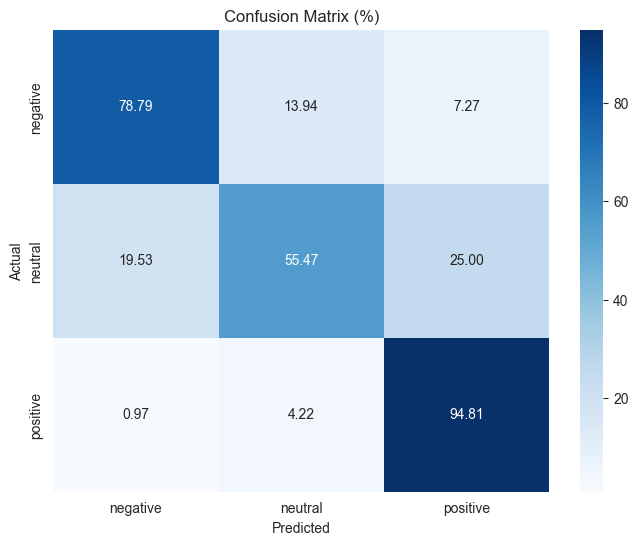

In [257]:
plot_confusion_matrix(y_test, y_pred_logistic, logistic_model.classes_)

---
## **Multinomial Naive Bayes**
---

In [258]:
# Định nghĩa tham số cần thử nghiệm
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

# Tìm kiếm tham số tối ưu
nb_model = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
nb_model.fit(X_train_tfidf, y_train)

# In kết quả
print("Best Parameters:", nb_model.best_params_)
print("Best Cross-Validation Accuracy:", nb_model.best_score_)

Best Parameters: {'alpha': 0.1, 'fit_prior': False}
Best Cross-Validation Accuracy: 0.7676983714483715


In [259]:
# Chọn mô hình tốt nhất để dự đoán
best_model_nb = nb_model.best_estimator_
y_pred_nb = best_model_nb.predict(X_test_tfidf)

# In kết quả
print("Accuracy on Test Data:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

Accuracy on Test Data: 0.7936772046589018

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.80      0.81       165
     neutral       0.70      0.35      0.47       128
    positive       0.80      0.97      0.88       308

    accuracy                           0.79       601
   macro avg       0.77      0.71      0.72       601
weighted avg       0.78      0.79      0.77       601



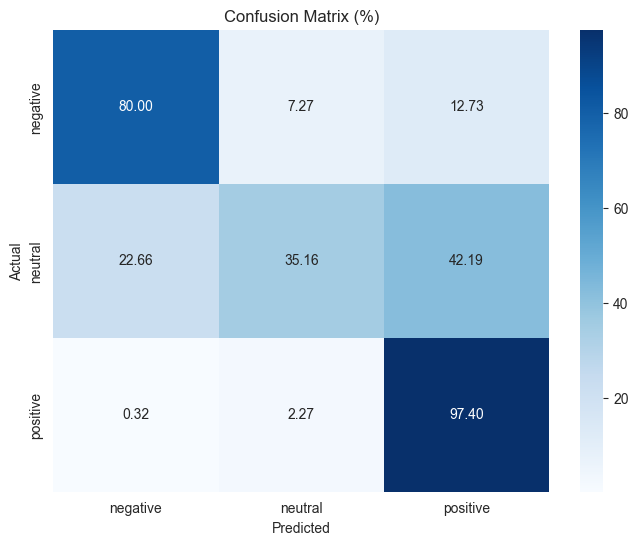

In [260]:
plot_confusion_matrix(y_test, y_pred_nb, nb_model.classes_)

---
## **SVM**
---

In [261]:
# Định nghĩa tham số cần thử nghiệm
param_grid = {
    'C': [0.1, 1, 10, 20],             # Độ phạt cho lỗi phân loại
    'kernel': ['linear', 'rbf'],   # Các kernel: tuyến tính và Gaussian RBF
    'gamma': ['scale', 'auto'],    # Chỉ dùng cho kernel phi tuyến
}

# Tìm kiếm tham số tối ưu
svm_model = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_model.fit(X_train_tfidf, y_train)

# In kết quả
print("Best Parameters:", svm_model.best_params_)
print("Best Cross-Validation Accuracy:", svm_model.best_score_)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.7801853776853778


In [262]:
# Tìm kiếm tham số tối ưu
best_model_svm = svm_model.best_estimator_
y_pred = best_model_svm.predict(X_test_tfidf)

# In kết quả
print("Accuracy on Test Data:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy on Test Data: 0.8219633943427621

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.80      0.82       165
     neutral       0.63      0.61      0.62       128
    positive       0.89      0.92      0.90       308

    accuracy                           0.82       601
   macro avg       0.79      0.78      0.78       601
weighted avg       0.82      0.82      0.82       601



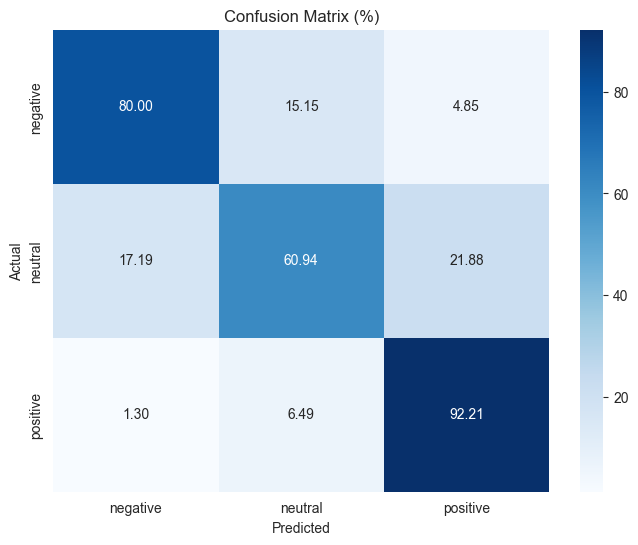

In [263]:
plot_confusion_matrix(y_test, y_pred, svm_model.classes_)

---
# **5. Deep Learning Model**
---